## **Mount drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Import **libraries**

In [2]:
# Based from the tutorial of Jason Brownlee on Recurrent Neural Networks
%matplotlib inline

from __future__ import print_function

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"


import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
import pandas as pd
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense
from keras.layers import LSTM,BatchNormalization,Activation,RepeatVector,TimeDistributed
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,make_scorer
from sklearn.model_selection import train_test_split,GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
plt.style.use('ggplot')


Using TensorFlow backend.


In [0]:
# fix random seed for reproducibility
#np.random.seed(10)

## **Read Dataset**

In [90]:
#Use the flood_data.csv dataset
file = '/content/drive/My Drive/Colab Notebooks/usgs_buffalo_bayou_05_26_2019.csv'#usgs_sm_lost_creek_final1.csv
df = pd.read_csv(file, engine='python')


columnTitles=['Date','Discharge(cft/sec)','precipitation(feet)','gage height(feet)'] #'SoilMoisture'


df = df.reindex(columns=columnTitles)

df = df.set_index('Date')
dataset   = df.values
dataset   = dataset.astype('float64')
print(dataset)
df.head()

#print(np.max(dataset[:,3]))

[[1010.      0.     41.37]
 [1000.      0.     41.35]
 [1000.      0.     41.33]
 ...
 [ 145.      0.     36.29]
 [ 136.      0.     36.2 ]
 [ 141.      0.     36.25]]


,Discharge(cft/sec),precipitation(feet),gage height(feet)
Date,,,
2019-01-26 00:00:00,1010.0,0.0,41.37
2019-01-26 00:15:00,1000.0,0.0,41.35
2019-01-26 00:30:00,1000.0,0.0,41.33
2019-01-26 00:45:00,988.0,0.0,41.28
2019-01-26 01:00:00,982.0,0.0,41.25


## **Instantiate Standard Scaler - Normalisation**

In [0]:

scaler  = StandardScaler()


In [0]:
# This function creates a sliding window of the dataset.
def create_dataset(dataset, sliding_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sliding_window-1):
        a = dataset[i:(i+sliding_window), :]
        dataX.append(a)
        dataY.append(dataset[(i + sliding_window), :])
    return np.array(dataX), np.array(dataY)

## **Create samples using sliding window approach**

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    #print(agg)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    #print(agg)
    return agg

In [0]:
df = series_to_supervised(dataset,4,1)
supervised_values = df.values

supervised_values_copy = supervised_values.copy()


## **Fit and transform the training data using the standard scaler. Reshape inputs so that the samples are in 3 dimensional and can be readily used by LSTM model**

In [94]:
np.random.shuffle(supervised_values)


train_len = int(len(supervised_values)*0.67)



train = supervised_values[:train_len,:]
test =  supervised_values[train_len:,:]

#scaler  = StandardScaler()

#val = scaler.fit_transform(dataset)


train = scaler.fit_transform(train)



test = scaler.transform(test)
    
trainX = train[:,0:4*3]
trainY = train[:,[-3,-1]]

testX = test[:,0:4*3]
testY = test[:,[-3,-1]]

trainX_shaped = trainX.reshape(len(trainX),4,3)
#trainY_shaped = trainY.reshape(len(trainY),4,3)
testX_shaped = testX.reshape(len(testX),4,3)
#testY_shaped = testY.reshape(len(testY),4,3)

print(scaler.inverse_transform(train)[:,-1])

[39.18 36.05 37.96 ... 36.25 37.71 46.83]


In [96]:
n_repeats = 10

from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
model = Sequential()
model.add(LSTM(200, input_shape=(4,3),use_bias=True))#return_sequences = True
# #model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(LSTM(200,use_bias=True, return_sequences = True))
# #model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(LSTM(200,use_bias=True)) # return_sequences = True -- add this to perform multi step ahead forecasting
# #model.add(BatchNormalization())
model.add(Dense(2,activation='relu', use_bias=True))#TimeDistributed(Dense(3,activation='relu', use_bias=True))
model.compile(loss='mean_absolute_error', optimizer='rmsprop', metrics=['mae'])#adam
plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/one_step_stacked_lstm.png', show_shapes=True, show_layer_names=True)

# tbCallBack = keras.callbacks.TensorBoard(log_dir='/content/drive/My Drive/Colab Notebooks/Graph', histogram_freq=0, write_graph=True, write_images=True)

# es = EarlyStopping(monitor='val_loss', mode='min', patience = 25,verbose=1)
for i in range(1):
  history = model.fit(trainX_shaped, trainY, batch_size = 100,epochs=100, verbose=2, validation_data=(testX_shaped,testY))#,callbacks=[es]
  print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, math.sqrt(history.history['loss'][-1]), math.sqrt(history.history['val_loss'][-1])))

Train on 7760 samples, validate on 3823 samples
Epoch 1/100
 - 4s - loss: 0.3767 - mean_absolute_error: 0.3767 - val_loss: 0.3562 - val_mean_absolute_error: 0.3562
Epoch 2/100
 - 1s - loss: 0.3553 - mean_absolute_error: 0.3553 - val_loss: 0.3868 - val_mean_absolute_error: 0.3868
Epoch 3/100
 - 1s - loss: 0.3540 - mean_absolute_error: 0.3540 - val_loss: 0.3472 - val_mean_absolute_error: 0.3472
Epoch 4/100
 - 1s - loss: 0.3524 - mean_absolute_error: 0.3524 - val_loss: 0.3536 - val_mean_absolute_error: 0.3536
Epoch 5/100
 - 1s - loss: 0.3513 - mean_absolute_error: 0.3513 - val_loss: 0.3571 - val_mean_absolute_error: 0.3571
Epoch 6/100
 - 1s - loss: 0.3501 - mean_absolute_error: 0.3501 - val_loss: 0.3533 - val_mean_absolute_error: 0.3533
Epoch 7/100
 - 1s - loss: 0.3491 - mean_absolute_error: 0.3491 - val_loss: 0.3448 - val_mean_absolute_error: 0.3448
Epoch 8/100
 - 1s - loss: 0.3488 - mean_absolute_error: 0.3488 - val_loss: 0.3467 - val_mean_absolute_error: 0.3467
Epoch 9/100
 - 1s - loss

## **Save model to file and print model summary**

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                17408     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 17,603
Trainable params: 17,603
Non-trainable params: 0
_________________________________________________________________
None


## **Plot training loss**

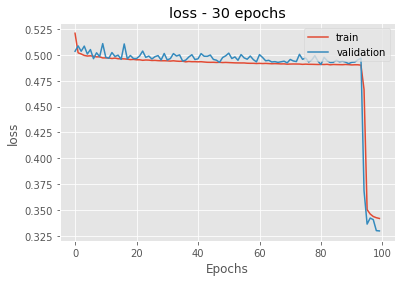

In [85]:
plt.plot(history.history['loss'],label="train")
plt.plot(history.history['val_loss'],label="validation")
plt.legend(loc="upper right")
plt.title("loss - 30 epochs")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

## **Calculate model metrics for training and test data**

In [61]:
#print(model.metrics_names)

# Print out the evaluation for both the
trainScore = model.evaluate(trainX_shaped, trainY, verbose=0)
print(trainScore)
#trainScore = math.sqrt(trainScore)
# print(trainScore)
#trainScore = scaler.inverse_transform(np.array([[trainScore]]))
print('Train Score: %.2f MAE' % (trainScore[0]))
testScore = model.evaluate(testX_shaped, testY, verbose=0)
# print(testScore)
#testScore = math.sqrt(testScore)
#testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f MAE' % (testScore[0]))

[0.33897978992191785, 0.33897978992191785]
Train Score: 0.34 MAE
Test Score: 0.33 MAE


In [97]:
trainPredict = model.predict(trainX_shaped)
testPredict  = model.predict(testX_shaped)



test_X = testX_shaped.reshape((testX_shaped.shape[0], 12))



# invert scaling for forecast
inv_yhat = np.concatenate((test_X,test[:,[-1]],testPredict.reshape(len(testPredict),2)), axis=1)
#.reshape(len(testPredict),12

#print(inv_yhat)


inv_yhat = scaler.inverse_transform(inv_yhat)



test_inv = scaler.inverse_transform(test)


print(mean_squared_error(test_inv[:,-1],inv_yhat[:,-1]))
print(mean_absolute_error(test_inv[:,-1],inv_yhat[:,-1]))

from sklearn.metrics import r2_score
print(inv_yhat[:,-1])



1.3952039032221344
0.9682995488795745
[37.69982088 41.17492133 37.69982088 ... 37.69982088 41.67660465
 37.69982088]


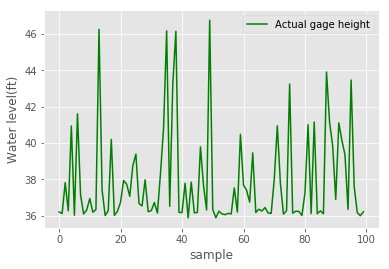

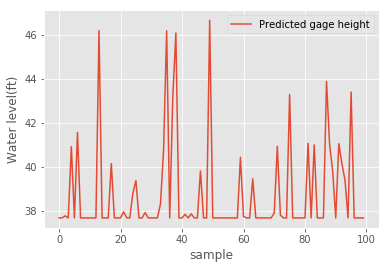

In [87]:
len1 = np.random.randint(0,len(test))

plt.plot(test_inv[len1:len1+100,-1],label="Actual gage height",color="green")
plt.legend(loc="upper right")
plt.xlabel("sample")
plt.ylabel("Water level(ft)")
plt.show()
plt.plot(inv_yhat[len1:len1+100,-1],label="Predicted gage height")
plt.legend(loc="upper right")
plt.xlabel("sample")
plt.ylabel("Water level(ft)")
plt.show()

# print(test[1000:1010,-1])
# print(inv_yhat[1000:1010,-1])

r-2 score : 0.80
r-2 score : 0.80
r-2 score : 0.80
r-2 score : 0.80


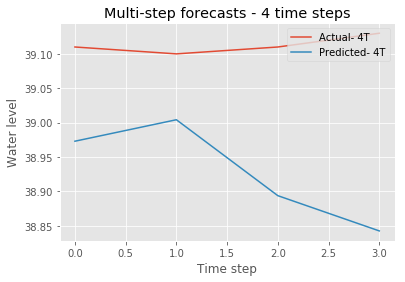

In [0]:
train_X = trainX_shaped.reshape((trainX_shaped.shape[0], 12))



# invert scaling for forecast
inv_yhat_train = np.concatenate((train_X,trainPredict.reshape((trainX_shaped.shape[0], 3))), axis=1)
#.reshape(len(testPredict),12

#print(inv_yhat)
train_inv = scaler.inverse_transform(train)

inv_yhat_train = scaler.inverse_transform(inv_yhat_train)


len1 = np.random.randint(0,len(test))
plt.plot(test[len1,[14,17,20,23]],label="Actual- 4T")
plt.plot(inv_yhat[len1,[14,17,20,23]],label="Predicted- 4T")
plt.title("Multi-step forecasts - 4 time steps")
plt.xlabel("Time step")
plt.ylabel("Water level")
plt.legend(loc="upper right")
plt.show()
# print(mean_squared_error(train[:,-1],inv_yhat_train[:,-1]))

## **This cell block is used to perform multi step ahead forecasts at different points in test data**

In [0]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    list_predictions = list()
    for i in range(int(len(testX)/10)):
      preds_moving = []                                    # Use this to store the prediction made on each test window
      
      #[testX[i,:].tolist()] 
      moving_test_window =  [testX[i*10]]        # Creating the first test window
      moving_test_window = np.array(moving_test_window)    # Making it an numpy array

      for i in range(n_future_preds):
          preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
          preds_moving.append(preds_one_step[0,:]) # get the value from the numpy 2D array and append to predictions
          preds_one_step = preds_one_step.reshape(1,1,4) # Reshaping the prediction to 3D array for concatenation with moving test window
          moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end

      preds_moving = scaler.inverse_transform(preds_moving)
      list_predictions.append(preds_moving)
    list_predictions = np.array(list_predictions)
    return list_predictions

## **This cell block is used to perform multi step ahead forecasts for a given sample in test data using predicted values - recursive strategy**

In [0]:
def moving_test_window_preds_full(n_future_preds,start_day):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    
    
    preds_moving = []                                    # Use this to store the prediction made on each test window

    #[testX[i,:].tolist()] 
    moving_test_window = look_aheadX_shaped[start_day,:].reshape(1,4,3)
#     moving_test_window =  [look_aheadX_shaped[start_day,:].tolist()]       # Creating the first test window
#     print(moving_test_window)
#     moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        
        preds_one_step = np.concatenate((np.array(look_ahead_forecast_actual_list_tranformed[start_day+1,[-2]]).reshape(1,-1),preds_one_step),axis=1)
        
        preds_moving.append(preds_one_step[0,:]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,3) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
    
    #preds_moving = scaler.inverse_transform(preds_moving)
      
    return preds_moving

## **This cell block is used to perform multi step ahead forecasts for a given sample in test data using actual values - Straightforward strategy**

In [0]:
def moving_test_window_preds_full_using_actual():

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    
    
    preds_moving = []                                    # Use this to store the prediction made on each test window
    

    for i in range(len(look_aheadX_shaped)):
      #print(look_aheadX_shaped[i,:].reshape(1,4,4))
      pred = model.predict(look_aheadX_shaped[i,:].reshape(1,4,3))[0,:]
      #print(pred)
      preds_moving.append(pred)
      
    return preds_moving

## **Randomly sample an index from dataset and perform multi step ahead forecasting using predictions and actuals - forecast horizon = 10. Plot the true values.**

[42.38 42.21 42.01 41.8 ]


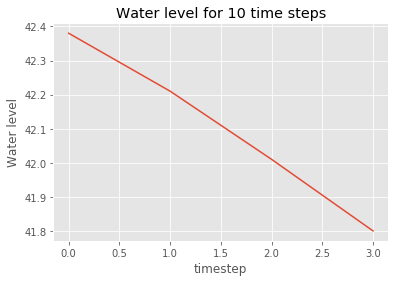

In [75]:
len1 = np.random.randint(0,len(supervised_values_copy))


look_ahead_forecast_actual_list = supervised_values_copy[len1:len1+4,:]

print(look_ahead_forecast_actual_list[:,-1])
plt.plot(look_ahead_forecast_actual_list[:,-1])
plt.title("Water level for 10 time steps")
plt.xlabel("timestep")
plt.ylabel("Water level")
plt.show()


look_ahead_forecast_actual_list_tranformed = scaler.transform(look_ahead_forecast_actual_list)


look_aheadX = look_ahead_forecast_actual_list_tranformed[:,0:12]
look_aheadY = look_ahead_forecast_actual_list_tranformed[:,12:]


look_aheadX_shaped = look_aheadX.reshape(len(look_aheadX),4,3)

## **Plot the predictions of the model using recursive strategy and straightforward strategy along with the true values of target variable**

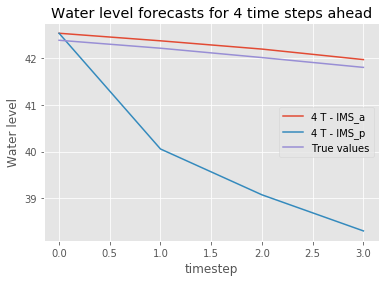

[42.38 42.21 42.01 41.8 ]
[42.53012507 42.36814534 42.1913179  41.9666905 ]
[42.53012507 40.05491906 39.07497214 38.30303293]


In [76]:
predictions = moving_test_window_preds_full(4,0)


predictions = np.asarray(predictions)
predictions = predictions.astype("float64")


inv_yhat_multiple = np.concatenate((look_aheadX,predictions), axis=1)

inv_yhat_multiple = scaler.inverse_transform(inv_yhat_multiple)


predictions_Using_actuals =  moving_test_window_preds_full_using_actual()
predictions_Using_actuals = np.asarray(predictions_Using_actuals)

predictions_Using_actuals = predictions_Using_actuals.astype("float64")


inv_yhat_actuals = np.concatenate((look_aheadX,look_ahead_forecast_actual_list_tranformed[:,[-2]],predictions_Using_actuals), axis=1)
inv_yhat_actuals = scaler.inverse_transform(inv_yhat_actuals)

plt.plot(inv_yhat_actuals[:,-1],label="4 T - IMS_a")
plt.plot(inv_yhat_multiple[:,-1],label="4 T - IMS_p")
plt.plot(look_ahead_forecast_actual_list[:,-1],label="True values")
plt.title("Water level forecasts for 4 time steps ahead")
plt.xlabel("timestep")
plt.ylabel("Water level")
plt.legend(loc="center right")
plt.show()


print(look_ahead_forecast_actual_list[:,-1])

print(inv_yhat_actuals[:,-1])
print(inv_yhat_multiple[:,-1])

## **Preparing training dataset for Encoder Decoder model**

In [0]:
df_new = series_to_supervised(dataset,4,4)

supervised_values_new = df_new.values

supervised_values_new_copy = supervised_values_new.copy()

np.random.shuffle(supervised_values_new)


train_len1 = int(len(supervised_values_new)*0.67)



train1 = supervised_values_new[:train_len1,:]
test1 =  supervised_values_new[train_len1:,:]

scaler1  = StandardScaler()

#val = scaler.fit_transform(dataset)


train1 = scaler1.fit_transform(train1)



test1 = scaler1.transform(test1)
    
trainX_new = train1[:,0:4*3]
trainY_new = train1[:,4*3:]

testX_new = test1[:,0:4*3]
testY_new = test1[:,4*3:]



In [0]:
trainX_shaped_new = trainX_new.reshape(len(trainX_new),4,3)
trainY_shaped_new = trainY_new.reshape(len(trainY_new),4,3)
testX_shaped_new = testX_new.reshape(len(testX_new),4,3)
testY_shaped_new = testY_new.reshape(len(testY_new),4,3)

print(scaler1.inverse_transform(test1)[:,-1])

[35.99 37.4  36.08 ... 41.   39.68 36.94]


# **Encoder Decoder model for Multi-step ahead forecasting**

In [0]:
model1 = Sequential()
model1.add(LSTM(200, activation='relu', input_shape=(4, 3)))
model1.add(RepeatVector(4))
model1.add(LSTM(200, activation='relu', return_sequences=True))
model1.add(TimeDistributed(Dense(3)))
model1.compile(optimizer='adam', loss='mse')

history1 = model1.fit(trainX_shaped_new, trainY_shaped_new, batch_size = 20,epochs=100, verbose=2,validation_data=(testX_shaped_new,testY_shaped_new))



Train on 7758 samples, validate on 3822 samples
Epoch 1/100
 - 10s - loss: 0.4670 - val_loss: 0.2210
Epoch 2/100
 - 7s - loss: 0.3124 - val_loss: 0.1951
Epoch 3/100
 - 7s - loss: 0.3006 - val_loss: 0.1923
Epoch 4/100
 - 7s - loss: 0.2954 - val_loss: 0.1883
Epoch 5/100
 - 7s - loss: 0.3047 - val_loss: 0.1975
Epoch 6/100
 - 7s - loss: 0.2883 - val_loss: 0.1964
Epoch 7/100
 - 7s - loss: 0.2971 - val_loss: 0.1996
Epoch 8/100
 - 7s - loss: 0.2935 - val_loss: 0.1918
Epoch 9/100
 - 7s - loss: 0.2907 - val_loss: 0.1989
Epoch 10/100
 - 7s - loss: 0.2895 - val_loss: 0.1980
Epoch 11/100
 - 7s - loss: 0.2843 - val_loss: 0.1943
Epoch 12/100
 - 7s - loss: 0.2794 - val_loss: 0.2008
Epoch 13/100
 - 7s - loss: 0.2805 - val_loss: 0.1942
Epoch 14/100
 - 7s - loss: 0.2902 - val_loss: 0.1957
Epoch 15/100
 - 7s - loss: 0.2869 - val_loss: 0.1818
Epoch 16/100
 - 7s - loss: 0.2843 - val_loss: 0.1858
Epoch 17/100
 - 7s - loss: 0.2787 - val_loss: 0.1894
Epoch 18/100
 - 7s - loss: 0.2708 - val_loss: 0.1943
Epoch 

## **Plot training loss**

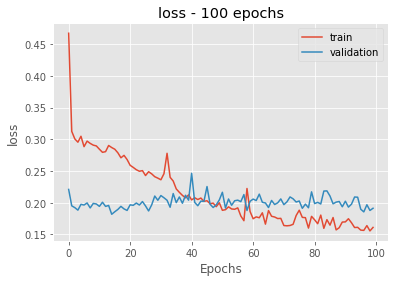

In [0]:
plt.plot(history1.history['loss'],label="train")
plt.plot(history1.history['val_loss'],label="validation")
plt.legend(loc="upper right")
plt.title("loss - 100 epochs")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

## **Encoder Decoder model**

In [0]:
print(model1.summary())

#model1.save_weights("/content/drive/My Drive/Colab Notebooks/encDec_8.h5")


model_json = model1.to_json()
with open("/content/drive/My Drive/Colab Notebooks/encDec_8_other.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("/content/drive/My Drive/Colab Notebooks/encDec_8_other.h5")
print("Saved model to disk")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 200)               163200    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 200)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 8, 200)            320800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 8, 3)              603       
Total params: 484,603
Trainable params: 484,603
Non-trainable params: 0
_________________________________________________________________
None
Saved model to disk


## **Model metrics for training and test data**

In [0]:
testScore = model1.evaluate(testX_shaped_new, testY_shaped_new, verbose=0)
#print(testScore)
print('Test Score: %.2f RMSE' % (math.sqrt(testScore)))

trainScore = model1.evaluate(trainX_shaped_new, trainY_shaped_new, verbose=0)
#print(trainScore)

print('Train Score: %.2f RMSE' % (math.sqrt(trainScore)))

Test Score: 0.44 RMSE
Train Score: 0.41 RMSE


## **Plot 10 Time step ahead predictions of Encoder Decoder Model**

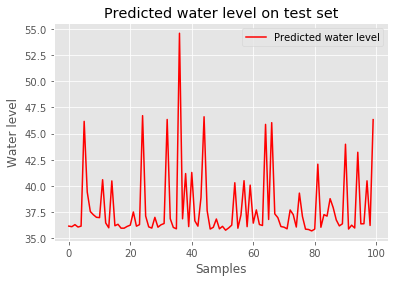

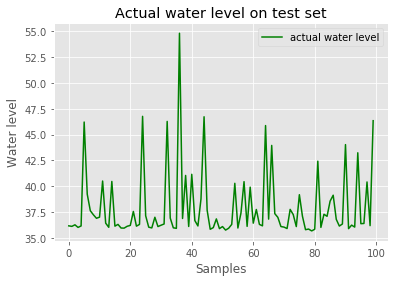

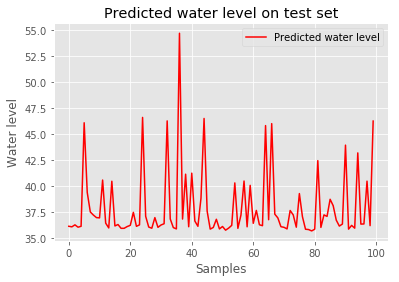

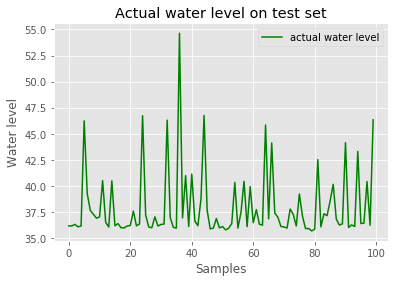

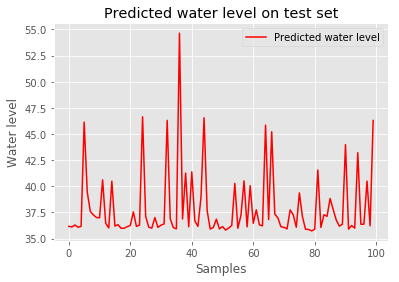

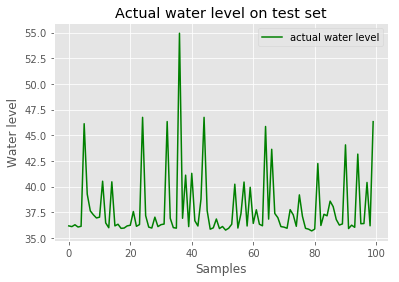

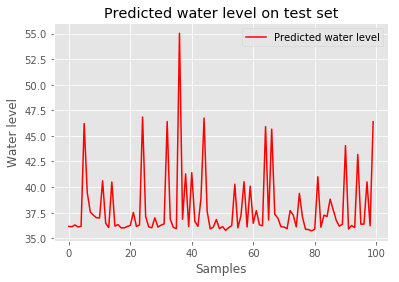

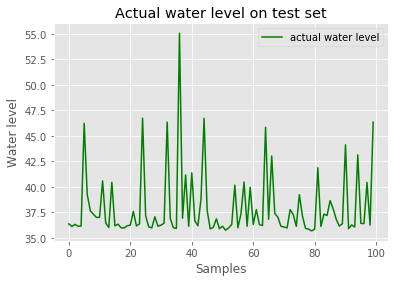

[36.36 36.11 36.31 36.13 36.14 46.22 39.25 37.64 37.31 36.99 37.   40.57
 36.46 36.01 40.44 36.17 36.33 35.98 35.96 36.18 36.23 37.58 36.16 36.36
 46.72 37.15 36.06 35.97 37.05 36.13 36.24 36.42 46.34 36.9  35.99 35.91
 55.05 36.91 41.16 36.12 41.36 36.66 36.17 38.79 46.71 37.69 35.87 36.01
 36.86 35.89 36.13 35.74 35.97 36.31 40.16 35.98 37.33 40.46 36.13 39.95
 36.3  37.76 36.29 36.2  45.83 36.81 43.02 37.38 37.02 36.13 36.05 35.96
 37.76 37.28 36.12 39.22 37.12 35.92 35.84 35.67 35.85 41.86 36.11 37.32
 37.18 38.64 37.83 36.8  36.14 36.38 44.11 35.89 36.26 36.06 43.13 36.41
 36.38 40.42 36.23 46.33]
[36.18 36.11 36.29 36.07 36.14 46.13 39.27 37.64 37.26 36.95 37.03 40.53
 36.47 36.   40.47 36.18 36.34 35.94 35.97 36.18 36.24 37.58 36.14 36.31
 46.75 37.18 36.06 35.97 37.03 36.11 36.3  36.36 46.34 36.92 36.01 35.96
 54.94 36.92 41.12 36.11 41.3  36.68 36.17 38.79 46.75 37.67 35.86 35.99
 36.85 35.92 36.12 35.77 35.95 36.34 40.24 35.97 37.37 40.45 36.17 39.94
 36.42 37.75 36.34 36.19 

In [0]:
pred_y = model1.predict(testX_shaped_new)


testX_reshape = testX_shaped_new.reshape(len(testX_shaped_new),12)

pred_y_reshape = pred_y.reshape(len(pred_y),12)


preds_inv = scaler1.inverse_transform(np.concatenate((testX_reshape,pred_y_reshape),axis=1))


test1_inv = scaler1.inverse_transform(test1)
len1 = np.random.randint(0,len(test))

plt.plot(preds_inv[len1:len1+100,20],label="Predicted water level",color="red")
plt.legend(loc= "upper right")
plt.title("Predicted water level on test set")
plt.xlabel("Samples")
plt.ylabel("Water level")
plt.show()
plt.plot(test1_inv[len1:len1+100,20],label="actual water level",color="green")
plt.legend(loc= "upper right")
plt.title("Actual water level on test set")
plt.xlabel("Samples")
plt.ylabel("Water level")
plt.show()

plt.plot(preds_inv[len1:len1+100,23],label="Predicted water level",color="red")
plt.legend(loc= "upper right")
plt.title("Predicted water level on test set")
plt.xlabel("Samples")
plt.ylabel("Water level")
plt.show()
plt.plot(test1_inv[len1:len1+100,23],label="actual water level",color="green")
plt.legend(loc= "upper right")
plt.title("Actual water level on test set")
plt.xlabel("Samples")
plt.ylabel("Water level")
plt.show()

plt.plot(preds_inv[len1:len1+100,17],label="Predicted water level",color="red")
plt.legend(loc= "upper right")
plt.title("Predicted water level on test set")
plt.xlabel("Samples")
plt.ylabel("Water level")
plt.show()
plt.plot(test1_inv[len1:len1+100,17],label="actual water level",color="green")
plt.legend(loc= "upper right")
plt.title("Actual water level on test set")
plt.xlabel("Samples")
plt.ylabel("Water level")
plt.show()

plt.plot(preds_inv[len1:len1+100,14],label="Predicted water level",color="red")
plt.legend(loc= "upper right")
plt.title("Predicted water level on test set")
plt.xlabel("Samples")
plt.ylabel("Water level")
plt.show()
plt.plot(test1_inv[len1:len1+100,14],label="actual water level",color="green")
plt.legend(loc= "upper right")
plt.title("Actual water level on test set")
plt.xlabel("Samples")
plt.ylabel("Water level")
plt.show()

[40.96923023 37.96311081 36.86997648 ... 36.0298825  41.00971669
 37.05216553]
[41.05578932 37.90234933 36.80688336 ... 36.04660307 41.15683078
 37.03099768]
[40.94291483 37.94362819 36.82902842 ... 35.99814496 41.02397663
 37.07221382]
[41.02861859 37.94403995 36.81966352 ... 36.00161031 41.13673325
 37.03049782]
r-2 score : 0.01
r-2 score : 0.02
r-2 score : 0.01
r-2 score : 0.02


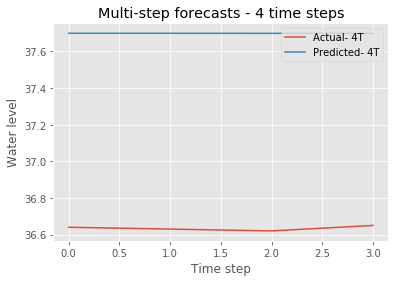

In [0]:
train_X_new = trainX_shaped_new.reshape((trainX_shaped_new.shape[0], 12))

train_predict = model1.predict(trainX_shaped_new)

# invert scaling for forecast
inv_yhat_train_new = np.concatenate((train_X_new,train_predict.reshape((train_predict.shape[0], 12))), axis=1)
#.reshape(len(testPredict),12

#print(inv_yhat)
train_inv_new = scaler.inverse_transform(train1)

inv_yhat_train_new = scaler.inverse_transform(inv_yhat_train_new)

print(train_inv_new[:,14])
print(inv_yhat_train_new[:,14])

print(train_inv_new[:,20])
print(inv_yhat_train_new[:,20])



print('r-2 score : %.2f' % (mean_squared_error(train_inv_new[:,14],inv_yhat_train_new[:,14])))

print('r-2 score : %.2f' % (mean_squared_error(train_inv_new[:,17],inv_yhat_train_new[:,17])))
print('r-2 score : %.2f' % (mean_squared_error(train_inv_new[:,20],inv_yhat_train_new[:,20])))
print('r-2 score : %.2f' % (mean_squared_error(train_inv_new[:,23],inv_yhat_train_new[:,23])))
len1 = np.random.randint(0,len(test))
plt.plot(test[len1,[14,17,20,23]],label="Actual- 4T")
plt.plot(inv_yhat[len1,[14,17,20,23]],label="Predicted- 4T")
plt.title("Multi-step forecasts - 4 time steps")
plt.xlabel("Time step")
plt.ylabel("Water level")
plt.legend(loc="upper right")
plt.show()
# print(mean_squared_error(train[:,-1],inv_yhat_train[:,-1]))

In [0]:
print('Test Score for time step t: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,19],preds_inv[:,19]))))

print('Test Score for time step t + 1: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,23],preds_inv[:,23]))))



print('Test Score for time step t + 2: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,27],preds_inv[:,27]))))

print('Test Score for time step t + 3: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,31],preds_inv[:,31]))))



print('Test Score for time step t + 4: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,35],preds_inv[:,35]))))

print('Test Score for time step t + 5: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,39],preds_inv[:,39]))))


print('Test Score for time step t + 6: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,43],preds_inv[:,43]))))

print('Test Score for time step t + 7: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,47],preds_inv[:,47]))))


print('Test Score for time step t + 8: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,51],preds_inv[:,51]))))

print('Test Score for time step t + 9: %f RMSE' %(math.sqrt(mean_squared_error(test1_inv[:,55],preds_inv[:,51]))))

Test Score for time step t: 0.008044 RMSE
Test Score for time step t + 1: 0.008211 RMSE
Test Score for time step t + 2: 0.008933 RMSE
Test Score for time step t + 3: 0.009983 RMSE
Test Score for time step t + 4: 0.011586 RMSE
Test Score for time step t + 5: 0.010954 RMSE
Test Score for time step t + 6: 0.010738 RMSE
Test Score for time step t + 7: 0.010775 RMSE
Test Score for time step t + 8: 0.011097 RMSE
Test Score for time step t + 9: 0.011451 RMSE


## ***Comparison of models - 10 time step ahead predictions using  Encoder Decoder model  and one step ahead forecasting model ***

In [0]:

# predictions = moving_test_window_preds(10)

# fig = plt.figure(facecolor='white')
# ax = fig.add_subplot(111)
# ax.plot(testY_transformed, label='True Data')
# # Pad the list of predictions to shift it in the graph to it's correct start
# for i, data in enumerate(predictions):
#   padding = []
#   for j in range((i+1) * 10):
#     padding.append(None)
#   for k in range(len(data[:,3])):
#     padding.append(data[k,3]) 
#   #print(padding)
#   plt.plot(padding , label='Prediction')
#   plt.legend()
#   plt.show()